In [1]:
## running in microsoft's planetary computer
import pystac_client
import planetary_computer
import rioxarray as rio
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely import Point
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.ndimage import gaussian_filter, rotate
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
# area of interest (near Finse, Norway)
aoi = shape({"coordinates": [[
            [7.411674112626002,60.53727135672119],
            [7.411674112626002,60.59445337285399],
            [7.283854231330025,60.59445337285399],
            [7.283854231330025,60.53727135672119],
            [7.411674112626002,60.53727135672119]]
        ],"type": "Polygon"})

west,south,east,north = aoi.bounds
aoi_series = gpd.GeoSeries([aoi], crs=4326)
prj = aoi_series.estimate_utm_crs()
minx,miny,maxx,maxy = aoi_series.to_crs(prj).total_bounds

In [3]:
## get contours in aoi from copernicus global DEM hosted on planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=['cop-dem-glo-30'],
                        intersects=aoi)
items = list(search.get_items())

# if aoi crosses multiple DEM tiles stitch 'em together
if len(items) > 1:
    data = []
    for item in items:
        signed_asset = planetary_computer.sign(item.assets["data"])
        with rio.open_rasterio(signed_asset.href) as f:
            data.append(f.squeeze().drop("band"))
    dem = ((xr.merge(data))
           .rio.set_crs(4326)
           .rio.clip_box(*aoi.bounds))
else:
    signed_asset = planetary_computer.sign(items[0].assets["data"])
    dem =  (rio.open_rasterio(signed_asset.href)
            .squeeze()
            .rio.set_crs(4326)
            .rio.clip_box(*aoi.bounds))
    
# reproject to local utm crs
dem_prj = dem.rio.reproject(prj, resolution=30, nodata=np.nan)

# dump out arrays
Z = dem_prj.values
X,Y = np.meshgrid(dem_prj.x.values, dem_prj.y.values)

In [4]:
## get mountain peaks, water features, and glaciers from OSM
features = ox.features_from_bbox(north=north, south=south,
                                 east=east, west=west,
                              tags={'natural':['peak','water','glacier']})

# reproject and separate out each feature tag
features = features.to_crs(prj).reset_index()

water = features.loc[features['natural']=='water']
glacier = features.loc[features['natural']=='glacier']
peaks = features.loc[features['natural']=='peak']

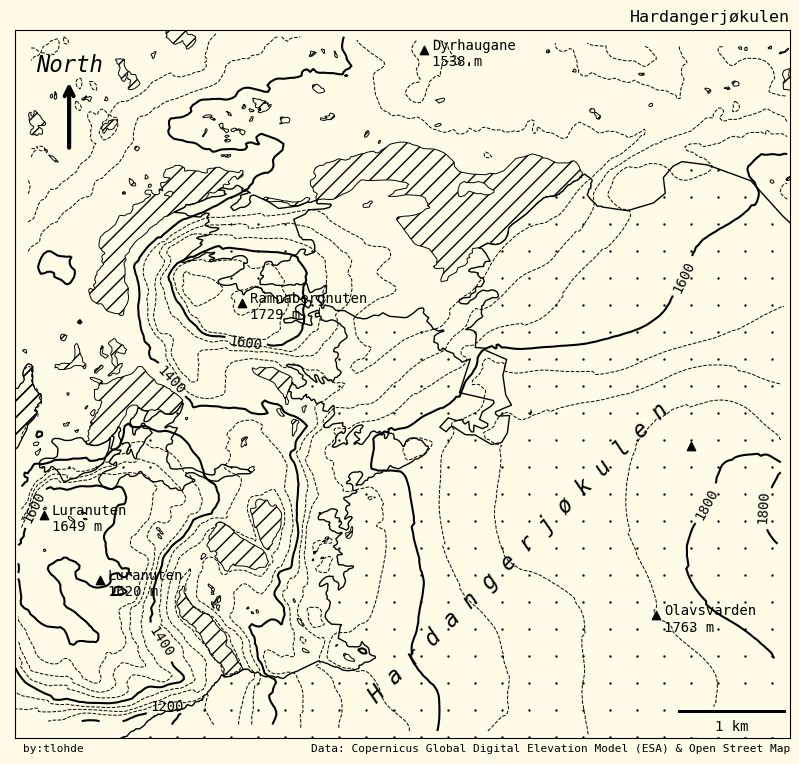

In [5]:
### plotting
fig, ax = plt.subplots(figsize=[10,10])

peaks.plot(marker='^', c='k', ax=ax)
water.plot(fc='none', linewidth=0.7, hatch='//', ax=ax)
glacier.plot(fc='none', ax=ax)

# custom stippling in glacier - fill the whole scene with points every 250 m, then clip
xstip = np.arange(dem_prj.x.min(), dem_prj.x.max(), 250)
ystip = np.arange(dem_prj.y.min(), dem_prj.y.max(), 250)
Xstip,Ystip = np.meshgrid(xstip,ystip)
points = gpd.GeoSeries([Point(x,y) for x,y in zip(Xstip.flat,Ystip.flat)],crs=prj)
points.clip(glacier).plot(ax=ax, c='k', markersize=0.5)

## neccessary to set limits before calling .contour() & .clabel()
## otherwise the labelling is too gappy
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy) 
ax.set_aspect('equal')

## plot contours:
## twice one every 50 m with dashed lines
## then every 200 m solid lines, that are then labelled
ax.contour(X,Y,Z,
           levels=[i for i in range(1200,1900,50) if i%200 !=0],
           colors='k',
           linewidths = 0.7, linestyles='dashed')
cplot = ax.contour(X,Y,Z, levels = range(1200,1900,200), colors = 'k')
ax.clabel(cplot, cplot.levels)

### annotate peaks with name and elevation (if it has a value for elevation)
peaks.loc[~peaks['ele'].isna()].apply(lambda q: ax.annotate(
    f"{q['name']}\n{q['ele']} m",
    xy=(q.geometry.x, q.geometry.y),
    xycoords='data',
    xytext=(q.geometry.x+75,q.geometry.y-150),
    textcoords ='data',
    # ha='right'
    ), axis=1)

# label glacier area
ax.annotate('H a r d a n g e r j ø k u l e n',
            xy=(0.45,0.05),
            xycoords='axes fraction',
            fontstyle='italic',
            fontsize=16,
            rotation=45)

# scale bar and north arrow
ax.add_artist(ScaleBar(dx=1,
                       units='m',
                       width_fraction=0.004,
                       location='lower right',
                       box_color='#FFFBE7'))

ax.annotate(text='North',
            xy=(0.07, 0.83),
            xytext=(0.07, 0.95),
            xycoords='axes fraction',
            arrowprops=dict(arrowstyle='<-',
                            lw=3,
                            color='k'),
            ha='center',
            va='center',
            fontstyle='italic',
            fontsize=16)

ax.set_title('Hardangerjøkulen',loc='right')

ax.annotate(text='Data: Copernicus Global Digital Elevation Model (ESA) & Open Street Map',
            xy=(1,-0.02), 
            xycoords='axes fraction', 
            ha='right',
            c='k', 
            fontsize=8,
            font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.02), 
            xycoords='axes fraction',
            ha='left',
            fontsize=8,
            font='DejaVu Sans Mono')

# remove ticks and colour in plot
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#FFFBE7')
fig.patch.set_facecolor('#FFFBE7')

## export it
fig.savefig('day11.png', bbox_inches='tight', dpi=600)

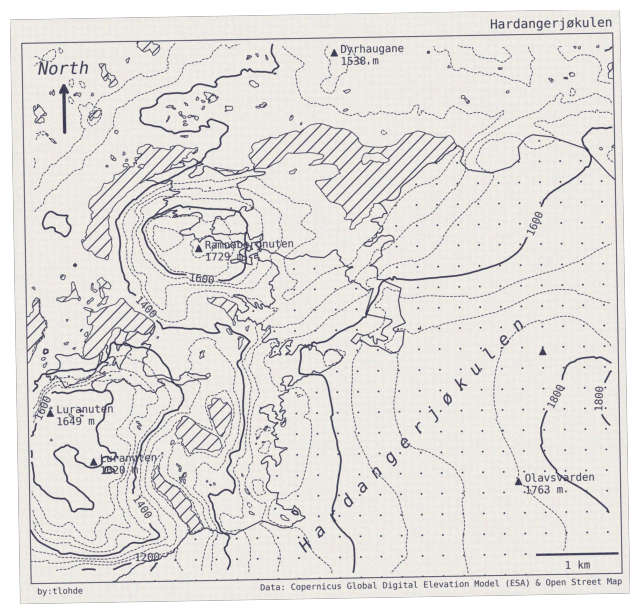

In [6]:
# then read it back in
img = plt.imread('day11.png')

# add some blur, some random noise, and make it wonky
# inspired by https://scipython.com/blog/old-style-matplotlib-charts/
blurred = gaussian_filter(img,sigma=0.6)
blr_noise = blurred+np.random.normal(loc=0, scale=0.2, size=img.shape)
blr_noise_rot = rotate(blr_noise,1)

# clip to between 0 and 1 for .imshow()'s sake
wrecked = np.clip(blr_noise_rot, a_min=0, a_max=1)

fig,ax=plt.subplots(figsize=[8,8]) # this is smaller than the original
ax.imshow(wrecked)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('none')
fig.savefig('day11_retro.png', bbox_inches='tight', dpi=300)